# Paper CHF - 6 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from imblearn.metrics import classification_report_imbalanced

import time

In [2]:
THREADS_TO_USE = 4

In [3]:
def parse_accuracy_per_class(conf_matrix, classes):
    acc_per_class = dict()
    for i, c in enumerate(classes):
        tn, fp, fn, tp = conf_matrix[i].ravel()
        acc_per_class[c] = (tp + tn) /(tp + tn + fp + fn)
    return acc_per_class

## Load dataset

In [4]:
data = pd.read_csv('../dataset/st_dataset_6beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,21.861233,21.421103,21.536569,6.108208,0.880920,1.079942,-0.914392,-1.844370,-1.138702,...,-0.068189,0.053454,-0.067161,0.067961,-0.093129,0.027961,-0.038417,-0.011442,0.005966,NSR
1,e0106,26.408089,27.988299,27.611772,7.776970,1.129695,1.195165,-0.806390,-1.774080,-1.792590,...,-0.031130,0.017521,-0.014034,0.023165,-0.043346,-0.016159,-0.012820,-0.007157,-0.012377,NSR
2,e0106,25.977641,26.935251,26.561891,7.477219,1.098311,1.176663,-0.849446,-1.805917,-1.623971,...,-0.025147,0.006059,-0.022267,0.043209,-0.061407,-0.003576,-0.026326,0.004760,-0.015544,NSR
3,e0106,25.189643,25.649484,25.620624,7.261496,1.066191,1.162694,-0.825414,-1.684836,-1.477246,...,-0.040045,0.024580,-0.029490,0.040770,-0.057996,-0.012361,-0.019814,0.007333,-0.030823,NSR
4,e0106,24.659920,24.559022,24.462891,6.972141,1.008067,1.143318,-0.881397,-1.797336,-1.316414,...,-0.064038,0.044904,-0.045340,0.042700,-0.063328,-0.010253,-0.004272,-0.024278,0.001717,NSR


In [5]:
data['label'].value_counts()

NSR    69911
ST-    14662
ST+     6585
Name: label, dtype: int64

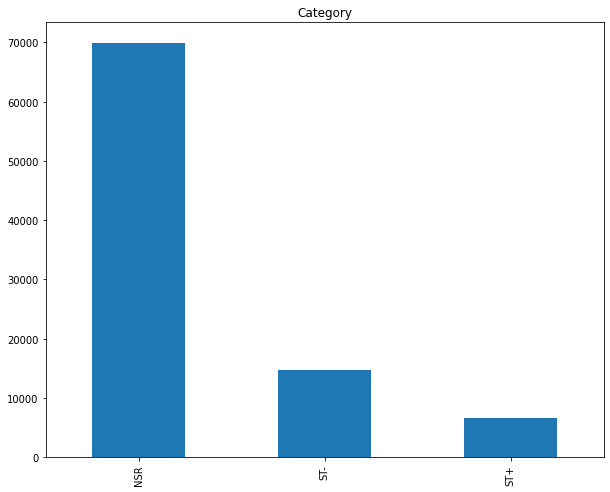

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.255941,0.126826,0.086712,0.088051,0.075713,-0.024569,0.012953,-0.001384,0.002394,...,-0.045708,-0.051747,-0.019303,-0.008486,-0.000878,-0.032264,-0.023128,-0.040651,-0.060588,-0.042833
dw_2,0.255941,1.000000,0.839774,0.443129,0.156197,0.418729,-0.461763,-0.218036,-0.003468,0.007413,...,-0.141060,0.127367,0.228143,0.164508,0.044436,0.028086,0.110780,-0.007514,-0.119066,-0.078764
dw_3,0.126826,0.839774,1.000000,0.617379,0.233068,0.346060,-0.532862,-0.300954,-0.002069,0.003404,...,-0.206438,0.110265,0.261460,0.116256,-0.047562,0.046009,0.046174,-0.030837,-0.133170,-0.047183
dw_4,0.086712,0.443129,0.617379,1.000000,0.899451,0.053813,-0.237258,-0.145344,-0.000228,0.000760,...,-0.142178,0.036774,0.117609,0.038427,-0.043639,0.039039,0.024440,-0.029533,-0.087767,-0.029773
dw_5,0.088051,0.156197,0.233068,0.899451,1.000000,-0.086599,-0.014596,-0.019561,0.000277,-0.000251,...,-0.064023,-0.004814,0.020295,0.008379,-0.014492,0.015851,0.009964,-0.028118,-0.040683,-0.015438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.032264,0.028086,0.046009,0.039039,0.015851,-0.077794,0.050496,0.076659,-0.000726,0.004327,...,-0.121386,-0.206635,-0.113087,0.008140,0.053560,1.000000,-0.006207,-0.033331,-0.303526,-0.194998
cfr_13,-0.023128,0.110780,0.046174,0.024440,0.009964,0.068140,0.004871,0.004627,0.000306,0.000798,...,0.120777,0.028507,-0.219328,-0.269074,-0.065839,-0.006207,1.000000,0.164767,0.075217,-0.175495
cfr_14,-0.040651,-0.007514,-0.030837,-0.029533,-0.028118,0.011829,0.019891,0.024541,0.001952,-0.001142,...,0.088392,0.207586,0.043674,-0.179302,-0.289882,-0.033331,0.164767,1.000000,0.131088,-0.151555
cfr_15,-0.060588,-0.119066,-0.133170,-0.087767,-0.040683,-0.021598,0.089608,0.046544,0.005107,-0.006644,...,0.251295,0.160789,-0.072934,-0.151000,-0.104688,-0.303526,0.075217,0.131088,1.000000,0.190121


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()
patient_ids = data["id"].values

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'fft_218', 'fft_161', 'fft_202', 'fft_172', 'fft_225', 'fft_144', 'mfw_6', 'fft_150', 'fft_180', 'fft_164', 'fft_211', 'fft_246', 'fft_134', 'fft_203', 'fft_229', 'fft_224', 'fft_162', 'fft_166', 'fft_201', 'fft_148', 'fft_219', 'fft_159', 'mfw_11', 'fft_152', 'fft_191', 'fft_216', 'fft_239', 'fft_213', 'mfw_9', 'fft_231', 'fft_158', 'mfw_12', 'fft_186', 'fft_208', 'fft_245', 'fft_130', 'fft_190', 'fft_169', 'fft_248', 'fft_192', 'fft_221', 'fft_179', 'fft_146', 'fft_140', 'mfw_5', 'fft_241', 'fft_222', 'fft_155', 'fft_209', 'mfw_10', 'fft_143', 'mfw_13', 'mfw_14', 'fft_175', 'fft_227', 'fft_244', 'fft_141', 'fft_154', 'fft_253', 'fft_250', 'cfr_16', 'mfw_15', 'fft_230', 'fft_189', 'fft_255', 'fft_142', 'fft_137', 'mfw_8', 'fft_199', 'fft_254', 'fft_198', 'fft_197', 'fft_196', 'fft_168', 'fft_243', 'fft_200', 'fft_151', 'fft_233', 'fft_207', 'fft_183', 'fft_145', 'fft_167', 'fft_249', 'fft_240', 'fft_139', 'fft_223', 'fft_187', 'fft_165', 'fft_232', 'fft_177', 'fft_206', 'fft_184', 'f

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_16
fft_17
fft_18
fft_19
fft_20
fft_21
fft_22
fft_23
fft_24
fft_25
fft_26
fft_27
fft_28
fft_29
fft_30
fft_31
fft_32
fft_33
fft_34
fft_35
fft_36
fft_37
fft_38
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_12
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 75


### Visualization best features

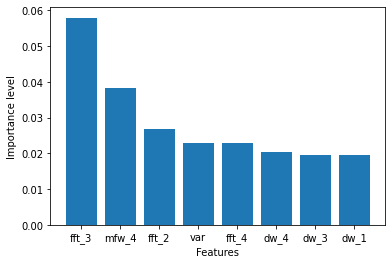

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,fft_1,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,21.861233,21.421103,21.536569,6.108208,0.880920,1.079942,-0.914392,-1.844370,-1.138702,-0.004752,...,0.006001,0.061446,-0.068189,0.053454,-0.067161,0.067961,-0.093129,0.027961,-0.038417,-0.011442
1,26.408089,27.988299,27.611772,7.776970,1.129695,1.195165,-0.806390,-1.774080,-1.792590,0.205786,...,0.027369,0.028651,-0.031130,0.017521,-0.014034,0.023165,-0.043346,-0.016159,-0.012820,-0.007157
2,25.977641,26.935251,26.561891,7.477219,1.098311,1.176663,-0.849446,-1.805917,-1.623971,-0.321053,...,0.008456,0.040828,-0.025147,0.006059,-0.022267,0.043209,-0.061407,-0.003576,-0.026326,0.004760
3,25.189643,25.649484,25.620624,7.261496,1.066191,1.162694,-0.825414,-1.684836,-1.477246,3.056053,...,0.029771,0.026605,-0.040045,0.024580,-0.029490,0.040770,-0.057996,-0.012361,-0.019814,0.007333
4,24.659920,24.559022,24.462891,6.972141,1.008067,1.143318,-0.881397,-1.797336,-1.316414,6.265323,...,-0.010154,0.059279,-0.064038,0.044904,-0.045340,0.042700,-0.063328,-0.010253,-0.004272,-0.024278


## Random Forest - L1SO

In [17]:
cvds = X_fsel.copy()
cvds["patient_id"] = patient_ids
cvds["label"] = y

patients = np.unique(cvds["patient_id"].values)
patients

array(['e0106', 'e0110', 'e0115', 'e0129', 'e0133', 'e0151', 'e0202',
       'e0203', 'e0204', 'e0205', 'e0206', 'e0207', 'e0208', 'e0210',
       'e0211', 'e0212', 'e0213', 'e0302', 'e0303', 'e0304', 'e0305',
       'e0306', 'e0403', 'e0404', 'e0405', 'e0406', 'e0408', 'e0409',
       'e0410', 'e0411', 'e0413', 'e0415', 'e0417', 'e0418', 'e0515',
       'e0601', 'e0602', 'e0603', 'e0605', 'e0606', 'e0607', 'e0609',
       'e0610', 'e0611', 'e0612', 'e0613', 'e0614', 'e0615', 'e0704',
       'e0801', 'e0808', 'e0817', 'e0818', 'e1301', 'e1302', 'e1304'],
      dtype=object)

In [18]:
classes = np.unique(label_encoder.inverse_transform(y))

In [19]:
result_df = pd.DataFrame()
tot = len(patients)
for i, patient in enumerate(patients):
    start_time = time.time()

    # Train and Test split
    df1 = cvds.loc[cvds["patient_id"] != patient]
    df2 = cvds.loc[cvds["patient_id"] == patient]

    y_train = df1["label"].values
    x_train = df1.loc[:, ~df1.columns.isin(['patient_id', 'label'])]
    y_test = df2["label"].values
    x_test = df2.loc[:, ~df2.columns.isin(['patient_id', 'label'])]

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_train, y_train)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report_imbalanced(y_true=y_test_dec, y_pred=y_pred_dec, labels=label_encoder.classes_, zero_division=1, output_dict=True)
    confusion_matrix = multilabel_confusion_matrix(y_pred=y_pred_dec, y_true=y_test_dec, labels=classes)

    # TOTAL
    tot_accuracy    = accuracy_score(y_true=y_test_dec, y_pred=y_pred_dec)
    tot_precision   = report['avg_pre']
    tot_recall      = report['avg_rec']
    tot_specificity = report['avg_spe']
    tot_f1          = report['avg_f1']

    # NSR
    nsr_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['NSR']
    nsr_precision   = report['NSR']['pre']
    nsr_recall      = report['NSR']['rec']
    nsr_specificity = report['NSR']['spe']
    nsr_f1          = report['NSR']['f1']

    # ST+
    st1_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st1_precision   = report['ST+']['pre']
    st1_recall      = report['ST+']['rec']
    st1_specificity = report['ST+']['spe']
    st1_f1          = report['ST+']['f1']

    # ST-
    st0_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st0_precision   = report['ST-']['pre']
    st0_recall      = report['ST-']['rec']
    st0_specificity = report['ST-']['spe']
    st0_f1          = report['ST-']['f1']

    # save result in result_df
    result_df = result_df.append({
        "accuracy": tot_accuracy,
        "precision": tot_precision,
        "recall": tot_recall,
        "specificity": tot_specificity,
        "f1": tot_f1,

        "nsr_accuracy": nsr_accuracy,
        "nsr_precision": nsr_precision,
        "nsr_recall": nsr_recall,
        "nsr_specificity": nsr_specificity,
        "nsr_f1": nsr_f1,

        "st+_accuracy": st1_accuracy,
        "st+_precision": st1_precision,
        "st+_recall": st1_recall,
        "st+_specificity": st1_specificity,
        "st+_f1": st1_f1,

        "st-_accuracy": st0_accuracy,
        "st-_precision": st0_precision,
        "st-_recall": st0_recall,
        "st-_specificity": st0_specificity,
        "st-_f1": st0_f1,
    }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(patients), "-", elapsed_seconds, "s")
    print("Tot: Accuracy", tot_accuracy, "Precision", tot_precision, "Recall", tot_recall, "Specificity", tot_specificity, "F1", tot_f1)
    print("NSR: Accuracy", nsr_accuracy, "Precision", nsr_precision, "Recall", nsr_recall, "Specificity", nsr_specificity, "F1", nsr_f1)
    print("ST+: Accuracy", st1_accuracy, "Precision", st1_precision, "Recall", st1_recall, "Specificity", st1_specificity, "F1", st1_f1)
    print("ST-: Accuracy", st0_accuracy, "precision", st0_precision, "Recall", st0_recall, "Specificity", st0_specificity, "F1", st0_f1)
    print("#---------------------#")

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
1 of 56 - 28.639768362045288 s
Tot: Accuracy 0.8194675540765392 Precision 0.8520595181076464 Recall 0.8194675540765392 Specificity 0.1805324459234609 F1 0.7381577876226711
NSR: Accuracy 0.8194675540765392 Precision 0.8194675540765392 Recall 1.0 Specificity 0.0 F1 0.9007773205304069
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
2 of 56 - 27.09006094932556 s
Tot: Accuracy 0.8020304568527918 Precision 0.8412223968667062 Recall 0.8020304568527918 Specificity 0.19796954314720813 F1 0.7139200686351611
NSR: Accuracy 0.8020304568527918 Precision 0.8020304568527918 Recall 1.0 Specificity 0.0 F1 0.8901408450704225
ST+: Accuracy 0.8020304568527918 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.8020304568527918 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
3 of 56 - 26.7659170627594 s
Tot: Accuracy 0.9165786694825766 Precision 0.8456991749145383 Recall 0.9165786694825766 Specificity 0.08002308334858887 F1 0.8797135218945721
NSR: Accuracy 0.9165786694825766 Precision 0.9194915254237288 Recall 0.9965556831228473 Specificity 0.0 F1 0.9564738292011019
ST+: Accuracy 0.9994720168954594 Precision 0.0 Recall 1.0 Specificity 0.9994720168954594 F1 0.0
ST-: Accuracy 0.9994720168954594 precision 0.0 Recall 0.0 Specificity 0.9971297359357061 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
4 of 56 - 28.2848539352417 s
Tot: Accuracy 0.8658280922431866 Precision 0.8838301930742893 Recall 0.8658280922431866 Specificity 0.13417190775681342 F1 0.8035662968459238
NSR: Accuracy 0.8658280922431866 Precision 0.8658280922431866 Recall 1.0 Specificity 0.0 F1 0.9280898876404495
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
5 of 56 - 28.467676162719727 s
Tot: Accuracy 0.9991023339317774 Precision 1.0 Recall 0.9991023339317774 Specificity 0.0 F1 0.9995509654243375
NSR: Accuracy 0.9991023339317774 Precision 1.0 Recall 0.9991023339317774 Specificity 0.0 F1 0.9995509654243376
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9991023339317774 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
6 of 56 - 27.83866262435913 s
Tot: Accuracy 0.9890710382513661 Precision 1.0 Recall 0.9890710382513661 Specificity 0.0 F1 0.9945054945054946
NSR: Accuracy 0.9890710382513661 Precision 1.0 Recall 0.9890710382513661 Specificity 0.0 F1 0.9945054945054945
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9890710382513661 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
7 of 56 - 26.60067343711853 s
Tot: Accuracy 0.7194976076555024 Precision 0.7987002699129192 Recall 0.7194976076555024 Specificity 0.3034190590111643 F1 0.6085862436978137
NSR: Accuracy 0.7194976076555024 Precision 0.7176399759181216 Recall 1.0 Specificity 0.022916666666666665 F1 0.8356116368734665
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.022916666666666665 Specificity 1.0 F1 0.04480651731160896
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
8 of 56 - 26.991791248321533 s
Tot: Accuracy 0.7869718309859155 Precision 0.7961342185605749 Recall 0.7869718309859155 Specificity 0.421162208927746 F1 0.737729856483474
NSR: Accuracy 0.7869718309859155 Precision 0.783596214511041 Recall 0.9841521394611727 Specificity 0.2239819004524887 F1 0.8724973656480505
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.8319327731092437 Recall 0.2239819004524887 Specificity 0.9841521394611727 F1 0.35294117647058826
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
9 of 56 - 27.7013521194458 s
Tot: Accuracy 0.8209109730848861 Precision 0.9837843934401606 Recall 0.8209109730848861 Specificity 0.7097494042736044 F1 0.8906116561808354
NSR: Accuracy 0.8209109730848861 Precision 0.9955583756345178 Recall 0.8223270440251572 Specificity 0.7083333333333334 F1 0.9006888633754304
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.047752808988764044 Recall 0.7083333333333334 Specificity 0.8223270440251572 F1 0.08947368421052632
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
10 of 56 - 26.99729633331299 s
Tot: Accuracy 0.6507699950322902 Precision 0.7727315914020368 Recall 0.6507699950322902 Specificity 0.3492300049677099 F1 0.5130958131160397
NSR: Accuracy 0.6507699950322902 Precision 0.6507699950322902 Recall 1.0 Specificity 0.0 F1 0.7884441769485404
ST+: Accuracy 0.6507699950322902 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.6507699950322902 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
11 of 56 - 27.166353464126587 s
Tot: Accuracy 0.7918256130790191 Precision 0.784989327928768 Recall 0.7918256130790191 Specificity 0.40780764784318274 F1 0.7540821876543852
NSR: Accuracy 0.794550408719346 Precision 0.8072575847709696 Recall 0.9624113475177305 Specificity 0.2376470588235294 F1 0.8780329990294403
ST+: Accuracy 0.9896457765667575 Precision 0.0 Recall 1.0 Specificity 0.9896457765667575 F1 0.0
ST-: Accuracy 0.9896457765667575 precision 0.7111111111111111 Recall 0.22588235294117648 Specificity 0.9723404255319149 F1 0.34285714285714286
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
12 of 56 - 27.536696434020996 s
Tot: Accuracy 0.7574503311258278 Precision 0.8162806729967984 Recall 0.7574503311258278 Specificity 0.24254966887417218 F1 0.6529129090721927
NSR: Accuracy 0.7574503311258278 Precision 0.7574503311258278 Recall 1.0 Specificity 0.0 F1 0.8619877531794631
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
13 of 56 - 27.05255150794983 s
Tot: Accuracy 0.9055064581917063 Precision 0.9144354876351821 Recall 0.9055064581917063 Specificity 0.09449354180829368 F1 0.8606026416777401
NSR: Accuracy 0.9055064581917063 Precision 0.9055064581917063 Recall 1.0 Specificity 0.0 F1 0.9504102747056725
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
14 of 56 - 28.066051959991455 s
Tot: Accuracy 0.8104976141785958 Precision 0.8464087684106002 Recall 0.8104976141785958 Specificity 0.18950238582140422 F1 0.7256639030559867
NSR: Accuracy 0.8104976141785958 Precision 0.8104976141785958 Recall 1.0 Specificity 0.0 F1 0.8953313253012049
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
15 of 56 - 25.91306447982788 s
Tot: Accuracy 0.7687128712871287 Precision 0.6687643325001956 Recall 0.7687128712871287 Specificity 0.1741124193642489 F1 0.7142882341741813
NSR: Accuracy 0.7687128712871287 Precision 0.8108786610878661 Recall 0.936231884057971 Specificity 0.006593406593406593 F1 0.8690582959641255
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.022222222222222223 Recall 0.006593406593406593 Specificity 0.936231884057971 F1 0.010169491525423728
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
16 of 56 - 27.574925899505615 s
Tot: Accuracy 0.9468784227820373 Precision 0.9155785361562943 Recall 0.9468784227820373 Specificity 0.06238217452046757 F1 0.9226226092610855
NSR: Accuracy 0.9468784227820373 Precision 0.947888096544158 Recall 0.9988439306358381 Specificity 0.010416666666666666 F1 0.9726991274978891
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.3333333333333333 Recall 0.010416666666666666 Specificity 0.9988439306358381 F1 0.0202020202020202
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
17 of 56 - 27.493513345718384 s
Tot: Accuracy 0.7400106553010123 Precision 0.7510984776629203 Recall 0.7400106553010123 Specificity 0.37405243900173263 F1 0.6652652854384214
NSR: Accuracy 0.7400106553010123 Precision 0.737842370039128 Recall 0.9858103061986557 Specificity 0.12825278810408922 F1 0.8439897698209718
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.7840909090909091 Recall 0.12825278810408922 Specificity 0.9858103061986557 F1 0.2204472843450479
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
18 of 56 - 26.40455913543701 s
Tot: Accuracy 0.9692174913693901 Precision 0.9701650542069836 Recall 0.9692174913693901 Specificity 0.030782508630609898 F1 0.9540668308030607
NSR: Accuracy 0.9692174913693901 Precision 0.9692174913693901 Recall 1.0 Specificity 0.0 F1 0.9843681519357195
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
19 of 56 - 26.485609531402588 s
Tot: Accuracy 0.8592493297587132 Precision 0.8790600809320847 Recall 0.8592493297587132 Specificity 0.14075067024128687 F1 0.7942016155376138
NSR: Accuracy 0.8592493297587132 Precision 0.8592493297587132 Recall 1.0 Specificity 0.0 F1 0.9242970439798126
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
20 of 56 - 26.15848422050476 s
Tot: Accuracy 0.9881932021466905 Precision 0.9786368925270771 Recall 0.9881932021466905 Specificity 0.010721806894900801 F1 0.9833918315406153
NSR: Accuracy 0.9881932021466905 Precision 0.9892550143266475 Recall 0.9989150090415914 Specificity 0.0 F1 0.9940615439985604
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 0.0 Specificity 0.9989150090415914 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
21 of 56 - 27.279502391815186 s
Tot: Accuracy 0.8166351606805293 Precision 0.850364091301241 Recall 0.8166351606805293 Specificity 0.20025673121136262 F1 0.7372849839761593
NSR: Accuracy 0.8166351606805293 Precision 0.816055625790139 Recall 1.0 Specificity 0.016891891891891893 F1 0.8987121475809259
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.016891891891891893 Specificity 1.0 F1 0.03322259136212625
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
22 of 56 - 26.851797819137573 s
Tot: Accuracy 0.6731780616078137 Precision 0.7799906410222396 Recall 0.6731780616078137 Specificity 0.3268219383921863 F1 0.5416861636287391
NSR: Accuracy 0.6731780616078137 Precision 0.6731780616078137 Recall 1.0 Specificity 0.0 F1 0.8046699595868883
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
23 of 56 - 27.658385038375854 s
Tot: Accuracy 0.357096981374438 Precision 0.6354254404065833 Recall 0.357096981374438 Specificity 0.6711362260295356 F1 0.2570324070410526
NSR: Accuracy 0.3692999357739242 Precision 0.3359209597741708 Recall 0.9206963249516441 Specificity 0.09519230769230769 F1 0.4922440537745606
ST+: Accuracy 0.3692999357739242 Precision 0.7843137254901961 Recall 0.07692307692307693 Specificity 0.9574468085106383 F1 0.14010507880910683
ST-: Accuracy 0.3692999357739242 precision 0.0 Recall 1.0 Specificity 0.9755940912010276 F1 0.0
#---------------------#
#---------------------#
24 of 56 - 26.663331985473633 s
Tot: Accuracy 0.8416095890410958 Precision 0.7122979011111764 Recall 0.8416095890410958 Specificity 0.155590483738041 F1 0.7715732727052724
NSR: Accuracy 0.8416095890410958 Precision 0.8437768240343347 Recall 0.9969574036511156 Specificity 0.0 F1 0.913993491399349
ST+: Accuracy 0.9066780821917808 Precision 0.0 Recall 0.0 Specificity 0.9981149

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
25 of 56 - 26.816641807556152 s
Tot: Accuracy 0.6948608137044968 Precision 0.7587135528426412 Recall 0.6948608137044968 Specificity 0.3633369982895514 F1 0.5894487381707406
NSR: Accuracy 0.6948608137044968 Precision 0.6902025177887247 Recall 0.9968379446640316 Specificity 0.06135986733001658 F1 0.815653298835705
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.9024390243902439 Recall 0.06135986733001658 Specificity 0.9968379446640316 F1 0.11490683229813664
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
26 of 56 - 27.217984676361084 s
Tot: Accuracy 0.7291390728476821 Precision 0.5366735064111596 Recall 0.7291390728476821 Specificity 0.26640523579628733 F1 0.6182741889256103
NSR: Accuracy 0.7291390728476821 Precision 0.7320478723404256 Recall 0.994579945799458 Specificity 0.0 F1 0.843355036384527
ST+: Accuracy 0.9973509933774835 Precision 0.0 Recall 1.0 Specificity 0.9973509933774835 F1 0.0
ST-: Accuracy 0.9973509933774835 precision 0.0 Recall 0.0 Specificity 0.998193315266486 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
27 of 56 - 27.500192642211914 s
Tot: Accuracy 0.8428005284015853 Precision 0.8502210994641641 Recall 0.8428005284015853 Specificity 0.23493448068566167 F1 0.845037544013354
NSR: Accuracy 0.8428005284015853 Precision 0.9112727272727272 Recall 0.9152666179693206 Specificity 0.15862068965517243 F1 0.913265306122449
ST+: Accuracy 0.9636723910171731 Precision 0.0 Recall 1.0 Specificity 0.9636723910171731 F1 0.0
ST-: Accuracy 0.9636723910171731 precision 0.27380952380952384 Recall 0.15862068965517243 Specificity 0.9554419284149014 F1 0.2008733624454149
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
28 of 56 - 27.162322998046875 s
Tot: Accuracy 0.13488372093023257 Precision 0.9537501925150162 Recall 0.13488372093023257 Specificity 0.9556047080229714 F1 0.16351024805533507
NSR: Accuracy 0.13488372093023257 Precision 0.052980132450331126 Recall 0.9904761904761905 Specificity 0.09095354523227384 F1 0.10058027079303675
ST+: Accuracy 0.9995348837209302 Precision 0.0 Recall 1.0 Specificity 0.9995348837209302 F1 0.0
ST-: Accuracy 0.9995348837209302 precision 1.0 Recall 0.09095354523227384 Specificity 1.0 F1 0.1667413715822501
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
29 of 56 - 26.83910322189331 s
Tot: Accuracy 0.14387351778656127 Precision 0.8768260713337187 Recall 0.14387351778656127 Specificity 0.8561264822134388 F1 0.036192094315347825
NSR: Accuracy 0.14387351778656127 Precision 0.14387351778656127 Recall 1.0 Specificity 0.0 F1 0.2515549412577747
ST+: Accuracy 0.14387351778656127 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.14387351778656127 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
30 of 56 - 26.32839298248291 s
Tot: Accuracy 0.9204069419509275 Precision 0.8550984517824313 Recall 0.9204069419509275 Specificity 0.08269320847626961 F1 0.886551574385401
NSR: Accuracy 0.9210053859964094 Precision 0.9248346361996392 Recall 0.9954692556634305 Specificity 0.007936507936507936 F1 0.958852867830424
ST+: Accuracy 0.9958108916816277 Precision 0.0 Recall 1.0 Specificity 0.9958108916816277 F1 0.0
ST-: Accuracy 0.9958108916816277 precision 0.0 Recall 0.0 Specificity 0.9993527508090615 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
31 of 56 - 26.488539695739746 s
Tot: Accuracy 0.9043097151205259 Precision 0.888377325901807 Recall 0.9043097151205259 Specificity 0.3911090894755919 F1 0.8923824891404701
NSR: Accuracy 0.9043097151205259 Precision 0.9254658385093167 Recall 0.9714751426242869 Specificity 0.323943661971831 F1 0.9479125248508947
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.5679012345679012 Recall 0.323943661971831 Specificity 0.9714751426242869 F1 0.4125560538116592
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
32 of 56 - 27.580264568328857 s
Tot: Accuracy 0.5134860050890585 Precision 0.7581505916934036 Recall 0.5134860050890585 Specificity 0.5492590929501572 F1 0.38066555111539324
NSR: Accuracy 0.5134860050890585 Precision 0.49710678590215673 Recall 1.0 Specificity 0.06274509803921569 F1 0.6640899508081518
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.06274509803921569 Specificity 1.0 F1 0.11808118081180811
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
33 of 56 - 26.624271392822266 s
Tot: Accuracy 0.847699287103046 Precision 0.8708947942519664 Recall 0.847699287103046 Specificity 0.152300712896954 F1 0.7778257927259096
NSR: Accuracy 0.847699287103046 Precision 0.847699287103046 Recall 1.0 Specificity 0.0 F1 0.9175727814801824
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
34 of 56 - 26.594001054763794 s
Tot: Accuracy 0.6392437404190087 Precision 0.9290069970539154 Recall 0.6392437404190087 Specificity 0.8347578026704645 F1 0.7299692614291107
NSR: Accuracy 0.6392437404190087 Precision 0.9836629406706793 Recall 0.624795193883124 Specificity 0.8492063492063492 F1 0.7641950567802271
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.13476070528967254 Recall 0.8492063492063492 Specificity 0.624795193883124 F1 0.2326086956521739
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
35 of 56 - 28.07147717475891 s
Tot: Accuracy 0.9462719298245614 Precision 0.8984646714259564 Recall 0.9462719298245614 Specificity 0.052053209947946794 F1 0.9217488262910799
NSR: Accuracy 0.9462719298245614 Precision 0.9478308621636463 Recall 0.9982648930017352 Specificity 0.0 F1 0.9723943661971831
ST+: Accuracy 0.9989035087719298 Precision 0.0 Recall 1.0 Specificity 0.9989035087719298 F1 0.0
ST-: Accuracy 0.9989035087719298 precision 0.0 Recall 0.0 Specificity 0.9994216310005783 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
36 of 56 - 26.992379426956177 s
Tot: Accuracy 0.9872739450770261 Precision 1.0 Recall 0.9872739450770261 Specificity 0.0 F1 0.9935962251432424
NSR: Accuracy 0.9872739450770261 Precision 1.0 Recall 0.9872739450770261 Specificity 0.0 F1 0.9935962251432424
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9872739450770261 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
37 of 56 - 27.77550959587097 s
Tot: Accuracy 0.8425827107790822 Precision 0.8556829448129668 Recall 0.8425827107790822 Specificity 0.40808850837283583 F1 0.8487459579946056
NSR: Accuracy 0.8425827107790822 Precision 0.9218559218559218 Recall 0.900417412045319 Specificity 0.350253807106599 F1 0.9110105580693815
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.2923728813559322 Recall 0.350253807106599 Specificity 0.900417412045319 F1 0.3187066974595843
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
38 of 56 - 26.84253191947937 s
Tot: Accuracy 0.06296851574212893 Precision 0.8065714932695067 Recall 0.06296851574212893 Specificity 0.8776492763964943 F1 0.04337366310475736
NSR: Accuracy 0.06371814092953523 Precision 0.043812451960030745 Recall 0.9193548387096774 Specificity 0.0220125786163522 F1 0.08363903154805576
ST+: Accuracy 0.06296851574212893 Precision 0.84375 Recall 0.02122641509433962 Specificity 0.9193548387096774 F1 0.04141104294478527
ST-: Accuracy 0.06296851574212893 precision 0.0 Recall 1.0 Specificity 0.9992503748125937 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
39 of 56 - 24.796262502670288 s
Tot: Accuracy 0.8111566018423746 Precision 0.8028191554287116 Recall 0.8111566018423746 Specificity 0.4784926419220063 F1 0.7826397178709951
NSR: Accuracy 0.8111566018423746 Precision 0.8197940503432495 Recall 0.9636852723604573 Specificity 0.32548179871520344 F1 0.885935085007728
ST+: Accuracy 0.9984646878198568 Precision 0.0 Recall 1.0 Specificity 0.9984646878198568 F1 0.0
ST-: Accuracy 0.9984646878198568 precision 0.7487684729064039 Recall 0.32548179871520344 Specificity 0.9657027572293208 F1 0.4537313432835821
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
40 of 56 - 25.209322452545166 s
Tot: Accuracy 0.8948985863552551 Precision 0.9010725261496058 Recall 0.8948985863552551 Specificity 0.5638546853293966 F1 0.8797133510347225
NSR: Accuracy 0.8948985863552551 Precision 0.8890392422192152 Recall 0.9947009841029523 Specificity 0.46405228758169936 F1 0.9389067524115755
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.9530201342281879 Recall 0.46405228758169936 Specificity 0.9947009841029523 F1 0.6241758241758242
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
41 of 56 - 25.729796648025513 s
Tot: Accuracy 0.3666281755196305 Precision 0.7694159386819293 Recall 0.3666281755196305 Specificity 0.6397124041905144 F1 0.2015761031920492
NSR: Accuracy 0.3666281755196305 Precision 0.3640579710144928 Recall 1.0 Specificity 0.006340579710144928 F1 0.5337866553336167
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.006340579710144928 Specificity 1.0 F1 0.012601260126012601
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
42 of 56 - 25.569390773773193 s
Tot: Accuracy 0.9313850063532402 Precision 0.9299440489093049 Recall 0.9313850063532402 Specificity 0.4113523401576913 F1 0.9306514648054749
NSR: Accuracy 0.9313850063532402 Precision 0.9623655913978495 Recall 0.9649595687331537 Specificity 0.37777777777777777 F1 0.9636608344549125
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.3953488372093023 Recall 0.37777777777777777 Specificity 0.9649595687331537 F1 0.38636363636363635
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
43 of 56 - 25.49034857749939 s
Tot: Accuracy 0.8565055762081785 Precision 0.8770962258675252 Recall 0.8565055762081785 Specificity 0.14349442379182156 F1 0.7903039037179189
NSR: Accuracy 0.8565055762081785 Precision 0.8565055762081785 Recall 1.0 Specificity 0.0 F1 0.9227072486984382
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
44 of 56 - 25.46014380455017 s
Tot: Accuracy 0.9979838709677419 Precision 1.0 Recall 0.9979838709677419 Specificity 0.0 F1 0.9989909182643794
NSR: Accuracy 0.9979838709677419 Precision 1.0 Recall 0.9979838709677419 Specificity 0.0 F1 0.9989909182643794
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9979838709677419 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
45 of 56 - 24.826518058776855 s
Tot: Accuracy 0.6111580726965342 Precision 0.37761766874696495 Recall 0.6111580726965342 Specificity 0.39248827610903175 F1 0.46680774411118764
NSR: Accuracy 0.6153846153846154 Precision 0.6153191489361702 Recall 0.9958677685950413 Specificity 0.010940919037199124 F1 0.760652288269332
ST+: Accuracy 0.6128486897717667 Precision 0.0 Recall 0.0 Specificity 0.9986225895316805 F1 0.0
ST-: Accuracy 0.6128486897717667 precision 0.0 Recall 1.0 Specificity 0.9940828402366864 F1 0.0
#---------------------#
#---------------------#
46 of 56 - 24.97691559791565 s
Tot: Accuracy 0.7548291233283804 Precision 0.814937882096311 Recall 0.7548291233283804 Specificity 0.2451708766716196 F1 0.6493703550394873
NSR: Accuracy 0.7548291233283804 Precision 0.7548291233283804 Recall 1.0 Specificity 0.0 F1 0.8602878916172735
ST+: Accuracy 0.9806835066864784 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.9806835066864784 precision 1.0 Recall 0

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
47 of 56 - 24.7777099609375 s
Tot: Accuracy 0.5168067226890757 Precision 0.6311595724290971 Recall 0.5168067226890757 Specificity 0.6280131833374718 F1 0.4841697721793692
NSR: Accuracy 0.5220588235294118 Precision 0.4603389830508475 Recall 0.8562421185372006 Specificity 0.28352835283528355 F1 0.5987654320987654
ST+: Accuracy 0.9873949579831933 Precision 0.0 Recall 1.0 Specificity 0.9873949579831933 F1 0.0
ST-: Accuracy 0.9873949579831933 precision 0.7530864197530864 Recall 0.2745274527452745 Specificity 0.8738965952080706 F1 0.4023746701846966
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
48 of 56 - 24.995803356170654 s
Tot: Accuracy 0.9786184210526315 Precision 0.9811851448797431 Recall 0.9786184210526315 Specificity 0.27555865360737397 F1 0.9798583281475534
NSR: Accuracy 0.9786184210526315 Precision 0.9908103592314118 Recall 0.9875104079933389 Specificity 0.26666666666666666 F1 0.9891576313594662
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.21052631578947367 Recall 0.26666666666666666 Specificity 0.9875104079933389 F1 0.23529411764705882
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
49 of 56 - 24.681877613067627 s
Tot: Accuracy 0.9975594874923734 Precision 1.0 Recall 0.9975594874923734 Specificity 0.0 F1 0.9987782529016493
NSR: Accuracy 0.9975594874923734 Precision 1.0 Recall 0.9975594874923734 Specificity 0.0 F1 0.9987782529016493
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9975594874923734 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
50 of 56 - 23.031919479370117 s
Tot: Accuracy 0.9962802231866088 Precision 1.0 Recall 0.9962802231866088 Specificity 0.0 F1 0.9981366459627329
NSR: Accuracy 0.9962802231866088 Precision 1.0 Recall 0.9962802231866088 Specificity 0.0 F1 0.9981366459627329
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9962802231866088 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
51 of 56 - 22.76497745513916 s
Tot: Accuracy 0.11627906976744186 Precision 0.893602820591199 Recall 0.11627906976744186 Specificity 0.8836220869846008 F1 0.02600381540697674
NSR: Accuracy 0.15010570824524314 Precision 0.12094557449147883 Recall 0.9606986899563319 Specificity 0.03848466626578473 F1 0.21484374999999997
ST+: Accuracy 0.12103594080338266 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.12103594080338266 precision 0.0 Recall 1.0 Specificity 0.9614164904862579 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
52 of 56 - 23.347642183303833 s
Tot: Accuracy 0.9405487804878049 Precision 1.0 Recall 0.9405487804878049 Specificity 0.0 F1 0.9693637077769051
NSR: Accuracy 0.9405487804878049 Precision 1.0 Recall 0.9405487804878049 Specificity 0.0 F1 0.9693637077769051
ST+: Accuracy 0.9519817073170732 Precision 0.0 Recall 1.0 Specificity 0.9519817073170732 F1 0.0
ST-: Accuracy 0.9519817073170732 precision 0.0 Recall 1.0 Specificity 0.9885670731707317 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
53 of 56 - 23.08373498916626 s
Tot: Accuracy 0.8150724637681159 Precision 0.8280222991194619 Recall 0.8150724637681159 Specificity 0.5560841614541455 F1 0.7882236563558457
NSR: Accuracy 0.8150724637681159 Precision 0.8048941798941799 Recall 0.9806607574536664 Specificity 0.390495867768595 F1 0.8841264075553942
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.8873239436619719 Recall 0.390495867768595 Specificity 0.9806607574536664 F1 0.5423242467718795
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
54 of 56 - 22.61967420578003 s
Tot: Accuracy 0.8784982935153584 Precision 0.883888621203831 Recall 0.8784982935153584 Specificity 0.23992067881665743 F1 0.835634776185742
NSR: Accuracy 0.8784982935153584 Precision 0.8776928422515636 Recall 0.9984189723320158 Specificity 0.12 F1 0.9341715976331361
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.9230769230769231 Recall 0.12 Specificity 0.9984189723320158 F1 0.21238938053097348
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
55 of 56 - 23.210658073425293 s
Tot: Accuracy 0.9056737588652483 Precision 0.9145711986318595 Recall 0.9056737588652483 Specificity 0.09432624113475177 F1 0.8608450986757885
NSR: Accuracy 0.9056737588652483 Precision 0.9056737588652483 Recall 1.0 Specificity 0.0 F1 0.9505024190547079
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#
#---------------------#
56 of 56 - 23.499536991119385 s
Tot: Accuracy 0.7765237020316027 Precision 0.8265029644537517 Recall 0.7765237020316027 Specificity 0.22683200266638387 F1 0.6796008883691155
NSR: Accuracy 0.7765237020316027 Precision 0.776355421686747 Recall 1.0 Specificity 0.003355704697986577 F1 0.874099194573972
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.003355704697986577 Specificity 1.0 F1 0.006688963210702341
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
result_df.head(10)

,accuracy,precision,recall,specificity,f1,nsr_accuracy,nsr_precision,nsr_recall,nsr_specificity,nsr_f1,st+_accuracy,st+_precision,st+_recall,st+_specificity,st+_f1,st-_accuracy,st-_precision,st-_recall,st-_specificity,st-_f1
0,0.819468,0.852060,0.819468,0.180532,0.738158,0.819468,0.819468,1.000000,0.000000,0.900777,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.000000,0.000000,1.000000,0.000000
1,0.802030,0.841222,0.802030,0.197970,0.713920,0.802030,0.802030,1.000000,0.000000,0.890141,0.802030,1.0,0.0,1.000000,0.0,0.802030,1.000000,1.000000,1.000000,1.000000
2,0.916579,0.845699,0.916579,0.080023,0.879714,0.916579,0.919492,0.996556,0.000000,0.956474,0.999472,0.0,1.0,0.999472,0.0,0.999472,0.000000,0.000000,0.997130,0.000000
3,0.865828,0.883830,0.865828,0.134172,0.803566,0.865828,0.865828,1.000000,0.000000,0.928090,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.000000,0.000000,1.000000,0.000000
4,0.999102,1.000000,0.999102,0.000000,0.999551,0.999102,1.000000,0.999102,0.000000,0.999551,1.000000,1.0,1.0,1.000000,1.0,1.000000,0.000000,1.000000,0.999102,0.000000
5,0.989071,1.000000,0.989071,0.000000,0.994505,0.989071,1.000000,0.989071,0.000000,0.994505,1.000000,1.0,1.0,1.000000,1.0,1.000000,0.000000,1.000000,0.989071,0.000000
6,0.719498,0.798700,0.719498,0.303419,0.608586,0.719498,0.717640,1.000000,0.022917,0.835612,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.000000,0.022917,1.000000,0.044807
7,0.786972,0.796134,0.786972,0.421162,0.737730,0.786972,0.783596,0.984152,0.223982,0.872497,1.000000,1.0,1.0,1.000000,1.0,1.000000,0.831933,0.223982,0.984152,0.352941
8,0.820911,0.983784,0.820911,0.709749,0.890612,0.820911,0.995558,0.822327,0.708333,0.900689,1.000000,1.0,1.0,1.000000,1.0,1.000000,0.047753,0.708333,0.822327,0.089474
9,0.650770,0.772732,0.650770,0.349230,0.513096,0.650770,0.650770,1.000000,0.000000,0.788444,0.650770,1.0,0.0,1.000000,0.0,0.650770,1.000000,1.000000,1.000000,1.000000


In [21]:
print("######## Total ########")
print("Accuracy",       result_df["accuracy"].mean())
print("Precision",      result_df["precision"].mean())
print("Recall",         result_df["recall"].mean())
print("Specificity",    result_df["specificity"].mean())
print("F1",             result_df["f1"].mean())

print("######## NSR ########")
print("Accuracy",       result_df["nsr_accuracy"].mean())
print("Precision",      result_df["nsr_precision"].mean())
print("Recall",         result_df["nsr_recall"].mean())
print("Specificity",    result_df["nsr_specificity"].mean())
print("F1",             result_df["nsr_f1"].mean())

print("######## ST+ ########")
print("Accuracy",       result_df["st+_accuracy"].mean())
print("Precision",      result_df["st+_precision"].mean())
print("Recall",         result_df["st+_recall"].mean())
print("Specificity",    result_df["st+_specificity"].mean())
print("F1",             result_df["st+_f1"].mean())

print("######## ST- ########")
print("Accuracy",       result_df["st-_accuracy"].mean())
print("Precision",      result_df["st-_precision"].mean())
print("Recall",         result_df["st-_recall"].mean())
print("Specificity",    result_df["st-_specificity"].mean())
print("F1",             result_df["st-_f1"].mean())

result_df.to_csv('result/multi_6beats_l1so.csv')

######## Total ########
Accuracy 0.7670088699004348
Precision 0.8490700932325888
Recall 0.7670088699004348
Specificity 0.30822249575171096
F1 0.7189661291925192
######## NSR ########
Accuracy 0.7680728181375585
Precision 0.7792789987002481
Recall 0.9735786201242705
Specificity 0.10114969189955428
F1 0.8350925223579911
######## ST+ ########
Accuracy 0.920221793853439
Precision 0.7790725665266106
Recall 0.8410383837860252
Specificity 0.9956387685315334
F1 0.6639556450313195
######## ST- ########
Accuracy 0.920221793853439
Precision 0.5495156709623965
Recall 0.34766161001525936
Specificity 0.978442905221058
F1 0.15275959901142638
